# SOLUTION NOTEBOOK

---

# CIFAR-10 softmax regression

Solution - Load and preprocess data
---

> **Exercise**: Load the data from the `cifar10-6k.npz` file. Split it into train/validation/test sets with respectively 5,000/500/500 images. Standardize them. Define a `get_batches(X, y, batch_size)` function to generate X/y batches of size `batch_size` using a Python generator.

In [1]:
import numpy as np
import os

# Load data
with np.load(os.path.join("c4_cifar10-6k.npz"), allow_pickle=False) as npz_file:
    cifar10 = dict(npz_file.items())

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    # Convert uint8 pixel values to float
    cifar10["data"].astype(np.float32),
    cifar10["labels"],
    test_size=1000,
    random_state=0,
)

# Split test into validation/test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=500, random_state=0
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [3]:
# Function to get batches of data
def get_batches(X, y, batch_size):
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # "yield" data between index i and i+b (not included)
        yield X[i : i + batch_size], y[i : i + batch_size]

Solution - Build and train model
---

> **Exercise:** Create a softmax regression network for the CIFAR-10 images. Initialize the parameters and the optimizer first. Use the graph mode and the `tf.function` decorator to define the different computations needed (logits, loss, accuracy, training). Train your model then using the batch generator.

**Hint**: Test different learning rates for the optimizer.

In [4]:
import tensorflow as tf

In [5]:
# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

In [6]:
# Compute the logits
@tf.function
def compute_logits(x, W, b):
    logits = tf.add(tf.matmul(x, W), b)
    return logits


# Compute the loss
@tf.function
def compute_loss(y, logits):
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    mean_ce = tf.reduce_mean(ce)
    return mean_ce


# Compute the accuracy
@tf.function
def compute_accuracy(y, logits):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    acc = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    return acc


# Train the model (optimization procedure)
@tf.function
def train(x, y, W, b):
    with tf.GradientTape() as tape:
        logits = compute_logits(x, W, b)
        loss = compute_loss(y, logits)
    optimizer.minimize(loss=loss, var_list=[W, b], tape=tape)
    return logits, loss

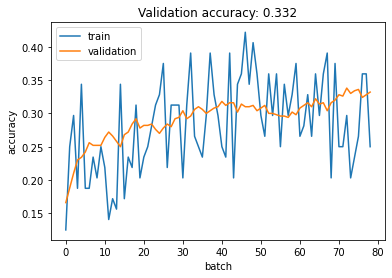

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

# Accuracy scores after each batch
train_acc_values = []
valid_acc_values = []


# Initialize the network parameters to zero
W = tf.Variable(initial_value=tf.zeros(shape=[3072, 10]))
b = tf.Variable(initial_value=tf.zeros(shape=[10]))


# Get batches of data
for X_batch, y_batch in get_batches(X_train, y_train, 64):
    # Run training
    train_logits, _ = train(X_batch, y_batch, W, b)

    # Evaluate training accuracy
    train_acc = compute_accuracy(y_batch, train_logits)
    train_acc_values.append(train_acc)

    # Evaluate validation accuracy
    valid_logits = compute_logits(X_valid, W, b)
    valid_acc = compute_accuracy(y_valid, valid_logits)
    valid_acc_values.append(valid_acc)

    # Get weight matrix and biases
    W_fitted = W.numpy()
    b_fitted = b.numpy()


# Plot accuracy values
plt.plot(train_acc_values, label="train")
plt.plot(valid_acc_values, label="validation")
plt.title(
    "Validation accuracy: {:.3f}".format(
        valid_acc_values[-1]  # Last validation accuracy value
    )
)
plt.xlabel("batch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Solution - Plot templates
---

> **Exercise**: Plot the templates of each output neuron. If you use the `imshow(array)` function to plot the array of weights, remember that it expects values between zero and one for 3-dimensional arrays. You can use the `MinMaxScaler` object from Scikit-learn to rescale the weights.

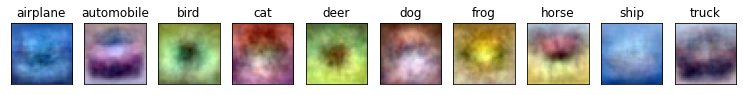

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Rescale each column of the weights matrix between 0 and 1
W_fitted_rescaled = MinMaxScaler().fit_transform(W_fitted)

# Create figure with 10 subplots
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(13, 2))

# Plot the weights for each class in a subplot
for i, axis in enumerate(axes):
    # Get weights of the i-th class
    weights = W_fitted_rescaled[:, i]

    # Reshape weight values into a 32x32x3 array
    template = weights.reshape(32, 32, 3)

    # Plot array
    axis.set_title(cifar10["names"][i])
    axis.imshow(template)
    axis.get_xaxis().set_visible(False)  # disable x-axis
    axis.get_yaxis().set_visible(False)  # disable y-axis

plt.show()

Solution - Evaluate model
---

> **Exercise**: Evaluate the accuracy of your network on the test set.

In [9]:
# Evaluate validation accuracy
test_logits = compute_logits(X_test, W, b)
test_acc = compute_accuracy(y_test, test_logits)
print("Test accuracy: {:.3f}".format(test_acc))

Test accuracy: 0.322
